In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot 
import statsmodels.formula.api as sm
import csv

In [2]:
#Read data from csv file
data = pd.read_csv('results_force.csv')
time = data['Time']
X = data['X']
Y = data['Y']
r = data['r']
data.head()


,Time,X,Y,r
0,0,-700.000000,0.000000,700.000000
1,1,-699.226460,0.000000,699.226460
2,2,-698.925746,4.656892,698.941261
3,3,-698.687585,5.951188,698.712930
4,4,-688.957344,7.088925,688.993813


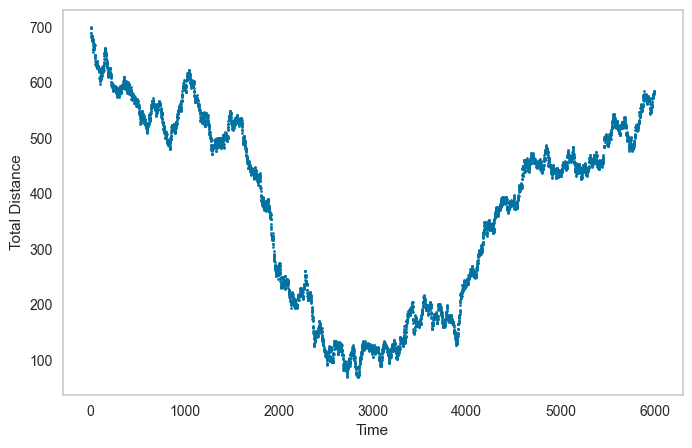

In [3]:
#Plot the time vs. total distance from origin
fig1 = plt.figure(figsize=(8,5))
plt.plot(time,r, 'ob', markersize = 2)
plt.xlabel('Time')
plt.ylabel('Total Distance')  
plt.grid(False)  

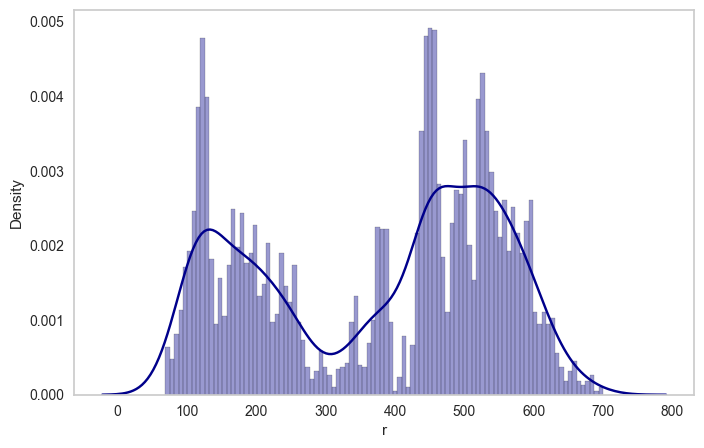

In [4]:
fig2 = plt.figure(figsize=(8,5))
warnings.filterwarnings('ignore')
sns.distplot(r, hist = True, kde = True, bins = 100, color = 'darkblue', hist_kws={'edgecolor': 'black'})
plt.grid(False)  

In [5]:
#calculate the mean square displacement MSD
#Reference: https://www.youtube.com/watch?v=yZ7zHg7goBc

#Define the variable rdiff
rdiff = np.zeros(len(time))

#create tau variable as an array of integers numbers from 1 to 200
tau = list(range(0,200))
#Define mean square displacement 
MSD = np.zeros(len(tau))
for j in range(1,len(tau)): #loop through tau
        sum = 0
        for i in range(j, len(rdiff)): #loop through rdiff
                rdiff[i] = (r[i]-r[i-j])**2 + sum
                sum = rdiff[i]
        MSD[j] = sum/len(rdiff) #calculate mean square displacement


In [6]:
#Save the results of MSD with tau as a csv file

with open('rdiff_box.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['tau', 'MSD'])
    for i in range(0,len(tau)):
        writer.writerow([tau[i], MSD[i]])

In [7]:
#Create a Dataframe with MSD and tau values
df = pd.DataFrame()
df['tau'] = tau
df['MSD'] = MSD
df.head()


,tau,MSD
0,0,0.000000
1,1,11.963697
2,2,23.772076
3,3,35.571396
4,4,47.442475


In [8]:
#Transform tau to array
def tau_to_array(tau):
    tau_array = np.zeros(len(tau))
    for i in range(len(tau)):
        tau_array[i] = tau[i]
    return tau_array

tau = tau_to_array(tau)

In [9]:
#Execute the linear regression model
regression = LinearRegression()
tau = tau.reshape(-1, 1) #needed for sklearn.linear_model.LinearRegression
regression.fit(tau, MSD)
predictions = regression.predict(tau)

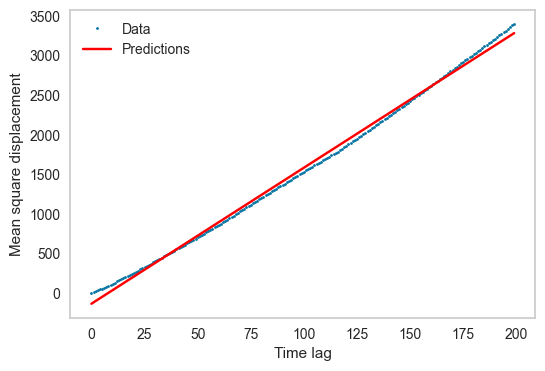

In [10]:
#Plot results
fig3 = plt.figure(figsize=(6,4))
plt.plot(tau, MSD, 'ob', markersize = 2, label = 'Data')
plt.plot(tau, predictions, color = 'red', label = 'Predictions')
plt.legend(loc = 'best')
plt.xlabel('Time lag')
plt.ylabel('Mean square displacement')
plt.grid(False)

In [11]:
#Linear regression results
regression_analysis = sm.ols(formula = 'MSD ~ tau', data = df)
regr_results = regression_analysis.fit()
regr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MSD   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 6.704e+04
Date:                Mon, 17 Apr 2023   Prob (F-statistic):          1.55e-252
Time:                        21:04:33   Log-Likelihood:                -1081.1
No. Observations:                 200   AIC:                             2166.
Df Residuals:                     198   BIC:                             2173.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -132.1934      7.629    -17.327      0.000    -147.238    -117.149
tau           17.1716      0.066    258.922      0.000      17.041      17.302
==============================================================================
Omnibus:                       22.927   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.824
Skew:                           0.686   Prob(JB):                     4.96e-05
Kurtosis:                       2.296   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

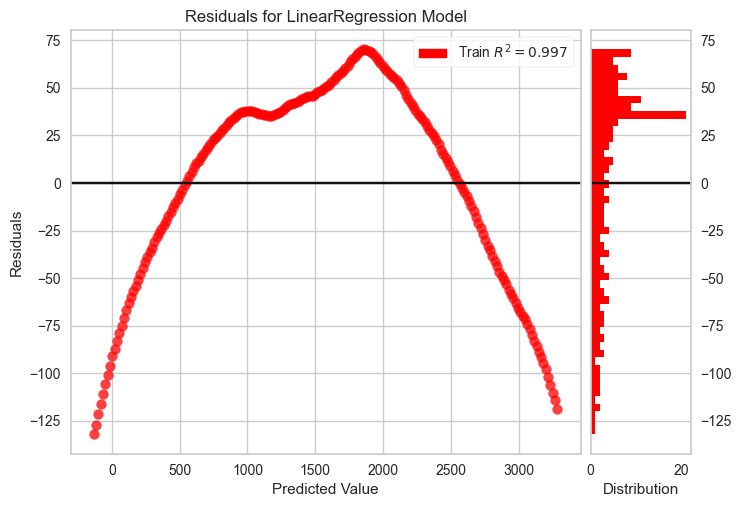

<AxesSubplot: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [12]:
# Residuals visualization
residuals = ResidualsPlot(regression, hist = True, train_color = 'red')
residuals.fit(tau, MSD)
residuals.poof()

In [13]:
#Determining diffusivity constant trhough linear regression
dimension = 2
#MSD = 2*dimension*D*tau

#Get the angular coefficient
m = regr_results.params[1]
Diffusivity = m/(2*dimension)
print('Diffusivity = {:.2f} px^2/step'.format(Diffusivity))

Diffusivity = 4.29 px^2/step
